In [65]:
# data manipulation
import pandas as pd
import datetime
pd.set_option("display.max_columns", 1000)
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt

In [159]:
x = pd.read_csv('tier1_converted.csv', parse_dates=['account_created_at','tier1_converted_at','tier2_converted_at'])
x.dtypes


account_id                           object
is_data_fully_recorded                 bool
treatment_group                      object
supporter                            object
sizing                               object
employees_in_account_plan             int64
marketing_source                     object
discount_code                        object
discount_percentage                 float64
account_created_at           datetime64[ns]
tier1_converted_at           datetime64[ns]
tier2_converted_at           datetime64[ns]
dtype: object

In [160]:
# full conversion indicator and study end point
x = x.join(x['tier2_converted_at'].notnull().to_frame('Tier2'))
tmp = datetime.datetime(2014,12,10)
x.loc[:, 'tier2_converted_at'] = x['tier2_converted_at'].fillna(tmp)

x.Tier2.value_counts()

True     34943
False    23962
Name: Tier2, dtype: int64

Text(0, 0.5, 'Days2Tier2')

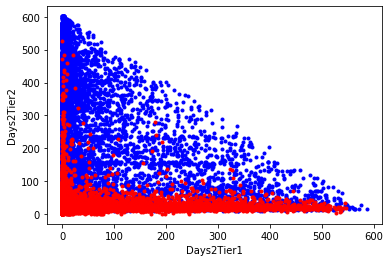

In [161]:
# dats to gestation and lifetime, 1 day processing time (model requirement)
x = x.join(
((x['tier1_converted_at'] - x['account_created_at'])/np.timedelta64(1,'D')).to_frame('Days2Tier1')).join(
((x['tier2_converted_at'] + np.timedelta64(1,'D') - x['tier1_converted_at'])/np.timedelta64(1,'D')).to_frame('Days2Tier2'))

plt.plot(x.Days2Tier1[~x.Tier2], x.Days2Tier2[~x.Tier2], 'b.')
plt.plot(x.Days2Tier1[x.Tier2], x.Days2Tier2[x.Tier2], 'r.')
plt.xlabel('Days2Tier1')
plt.ylabel('Days2Tier2')

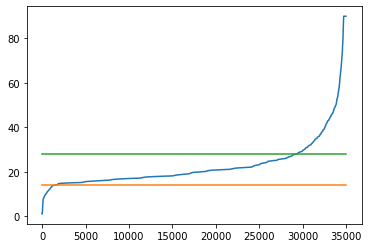

In [166]:

# limit to 150 days out
cutoff=90
x.loc[x.Days2Tier2>cutoff, 'Days2Tier2'] = cutoff

# 2 week intervals look good 
plt.plot(sorted(x.Days2Tier2[x.Tier2]))
plt.plot([0,35000],[14]*2)
plt.plot([0,35000],[28]*2)


In [167]:
# unit is in days
interval_length = 14.
interval_bounds = np.arange(0, x.Days2Tier2.max() + 1 + interval_length, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)
interval_bounds

array([ 0., 14., 28., 42., 56., 70., 84., 98.])

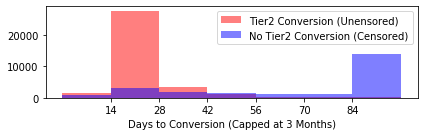

In [263]:
plt.figure(figsize=(6,2))
# confirmed early Tier 2 conversion, if at all
plt.hist(x[x.Tier2].Days2Tier2.values, bins=interval_bounds,
        color='red', alpha=0.5, lw=0,
        label='Tier2 Conversion (Unensored)')
plt.hist(x[~x.Tier2].Days2Tier2.values, bins=interval_bounds,
        color='blue', alpha=0.5, lw=0,
        label='No Tier2 Conversion (Censored)')
plt.legend()
plt.xticks(range(14,90,14))

plt.xlabel("Days to Conversion (Capped at 3 Months)")
plt.tight_layout()
plt.savefig('obv.png')

In [170]:
# Kaplan Meier data structure

last_period = np.floor((x.Days2Tier2 - 0.0001) / interval_length).astype(int)
tier2 = np.zeros((x.shape[0], n_intervals))
tier2[range(x.shape[0]),last_period] = (x.Tier2).astype(int)

exposure = np.greater_equal.outer(x.Days2Tier2, interval_bounds[:-1])* interval_length
exposure[range(x.shape[0]), last_period] = x.Days2Tier2 - interval_bounds[last_period]
exposure[exposure>interval_length]=interval_length


In [ ]:
# features -- nothing fancy use-wise here

In [211]:
# NoMissingData
display(x.is_data_fully_recorded.fillna('NA').value_counts())

X = (x.is_data_fully_recorded==True).astype(int).to_frame('NoMissingData')

False    52108
True      6797
Name: is_data_fully_recorded, dtype: int64

In [212]:
# treatment indicators
display(x.treatment_group.fillna('NA').value_counts())

X = X.join(pd.get_dummies(x.treatment_group))

NA           55992
Control       1541
Treatment     1372
Name: treatment_group, dtype: int64

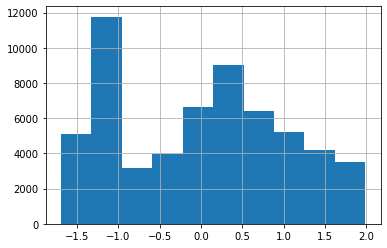

In [213]:
# gestation: time to tier1
X = X.join(((np.log(x.Days2Tier1)-np.log(x.Days2Tier1).mean())/np.log(x.Days2Tier1).std()).to_frame('gestation'))

X.gestation.hist()

In [214]:
# support medium or strong
display(x.supporter.fillna('NA').value_counts())

X = X.join(((x.supporter=='medium')|(x.supporter=='strong')).astype(int).to_frame('support'))

weak      36677
medium    15761
NA         6329
strong      138
Name: supporter, dtype: int64

In [215]:
# sizing -- size-08 reference; size-09 dropped
display(x.sizing.fillna('NA').value_counts())

X = X.join(pd.get_dummies(x.sizing).iloc[:,:7])


size-08    20945
size-02     8154
size-03     7225
size-04     6196
size-06     5969
size-05     4675
size-01     4559
size-07      903
NA           278
size-09        1
Name: sizing, dtype: int64

In [216]:
display(x.employees_in_account_plan.fillna('NA').value_counts())

X = X.join(((x.employees_in_account_plan==1)).astype(int).to_frame('employee_1'))
X = X.join(((x.employees_in_account_plan==2)).astype(int).to_frame('employee_2'))
X = X.join(((x.employees_in_account_plan>3)).astype(int).to_frame('employee_3p'))

1     44736
2     11497
3      2023
4       449
5       128
6        41
7        18
8         6
10        3
9         2
13        1
12        1
Name: employees_in_account_plan, dtype: int64

In [218]:
display(x.marketing_source.fillna('NA').value_counts())

X = X.join(pd.get_dummies(x.marketing_source))

NA           34195
source-04    13721
source-03     3897
source-06     3412
source-05     1612
source-02     1084
source-01      984
Name: marketing_source, dtype: int64

In [220]:
display(x.discount_code.fillna('NA').value_counts())

X = X.join(((x.discount_code=='code-04')).astype(int).to_frame('code-04'))
X = X.join(((x.discount_code=='code-53')).astype(int).to_frame('code-53'))
X = X.join(((x.discount_code=='code-120')).astype(int).to_frame('code-120'))


NA          29187
code-04     22898
code-53      2068
code-120     1911
code-171      356
code-83       324
code-164      248
code-36       233
code-138      169
code-62       146
code-144      103
code-153      101
code-26        85
code-107       65
code-95        64
code-94        61
code-10        55
code-61        51
code-03        43
code-58        41
code-60        39
code-59        37
code-121       35
code-104       35
code-96        34
code-32        32
code-167       28
code-72        24
code-52        20
code-132       20
            ...  
code-172        1
code-57         1
code-21         1
code-47         1
code-31         1
code-18         1
code-90         1
code-70         1
code-91         1
code-115        1
code-84         1
code-65         1
code-106        1
code-176        1
code-125        1
code-25         1
code-135        1
code-86         1
code-88         1
code-74         1
code-33         1
code-85         1
code-30         1
code-22         1
code-29   

In [226]:
display(x.discount_percentage.fillna('NA').value_counts())

X = X.join(((x.discount_percentage.fillna(50.)-50)/25).to_frame("discount_val"))

50.0     30111
20.0     20158
NA        3620
60.0      2910
100.0     2033
85.0        23
80.0        16
65.0        11
75.0        10
55.0         6
99.0         4
90.0         3
Name: discount_percentage, dtype: int64

In [229]:
X.head()

,NoMissingData,Control,Treatment,gestation,support,size-01,size-02,size-03,size-04,size-05,size-06,size-07,employee_1,employee_2,employee_3p,source-01,source-02,source-03,source-04,source-05,source-06,code-04,code-53,code-120,discount_val
0,0,0,0,0.805088,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0
1,0,0,0,1.789140,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0.0
2,0,0,0,0.544474,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,1.886833,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,-1.2
4,0,0,0,0.536194,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0


In [231]:
with pm.Model() as model:

    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)

    beta = pm.Normal('beta', 0, sigma=3, shape=(X.shape[1],1))
    lambda_ = tt.outer(tt.exp(tt.dot(X,beta)), lambda0)
    mu = exposure * lambda_

    obs = pm.Poisson('obs', mu, observed=tier2)

In [232]:

with model:
    trace = pm.sample(500)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, lambda0]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [27:24<00:00,  1.39s/draws]  
The acceptance probability does not match the target. It is 0.9911767057481957, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8988346518332168, but should be close to 0.8. Try to increase the number of tuning steps.


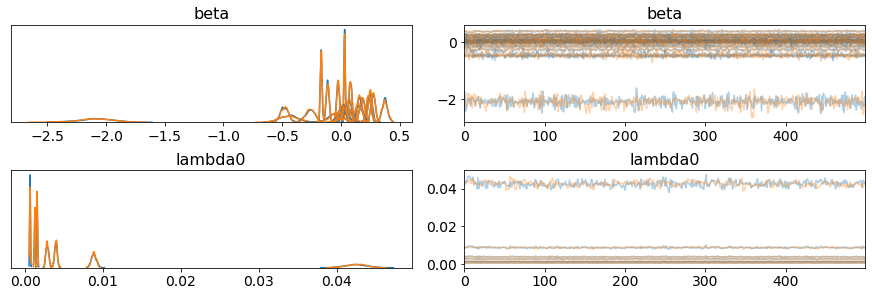

In [233]:
_=pm.traceplot(trace)

In [250]:
good_effects = ((trace['beta']>0).mean(axis=0)>.99).T[0]

pd.Series(trace['beta'].mean(axis=0)[good_effects].T[0],
            index=X.columns[good_effects])





gestation    0.031439
size-01      0.375168
size-02      0.249675
size-03      0.275239
size-04      0.235964
size-05      0.182850
size-06      0.160628
source-03    0.069091
source-06    0.150724
code-04      0.081584
dtype: float64